# Research Question 4:
Interpret if there is a bias in the data

RQ4: Is there a bias within the quotes and sentiment or rating of a movie w.r.t gender, ethnicity, etc.?

Possible Bias:
- Women tend to vote less on movies
- How successful are movies liked by men/women?
- Average vote by men?
- Young vs old generation? Which generation influences movie success the most?
- Bias per country??? (But Box office is limited to US only!)
- Bias on quote: Get gender of quoted person -> wikidata

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp, pearsonr, ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
movies = pd.read_csv('data/IMDb/IMDb movies.csv')

/opt/miniconda3/envs/ada/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
def clean_imdb(df):
    imdb = df.rename(columns = {'worlwide_gross_income':'worldwide_gross_income'})
    imdb = imdb.drop(imdb.index[83917])
    imdb['year'] = imdb['year'].astype(int)
    imdb = imdb[imdb['year']>2014]
    imdb = imdb.dropna()
    imdb['budget'] = imdb['budget'].map(lambda x: x.lstrip('$EURCZKNYGBPWILSADMXNJPYOP')).astype(int)
    imdb['worldwide_gross_income'] = imdb['worldwide_gross_income'].map(lambda x: x.lstrip('$EURCZKNYGBPWILSADMXNJPYOP')).astype(int)
    imdb['usa_gross_income'] = imdb['usa_gross_income'].map(lambda x: x.lstrip('$EURCZKNYGBPWILSADMXNJPYOP')).astype(int)
    imdb['date_published'] = pd.to_datetime(imdb['date_published'])
    return imdb

movies = clean_imdb(movies)

In [4]:
def standardize_col(col):
    try:
        return (col - col.mean())/col.std()
    except:
        return col

In [5]:
ratings = pd.read_csv('data/IMDb/IMDb ratings.csv')

In [6]:
movies.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worldwide_gross_income,metascore,reviews_from_users,reviews_from_critics
43822,tt0369610,Jurassic World,Jurassic World,2015,2015-06-11,"Action, Adventure, Sci-Fi",124,USA,English,Colin Trevorrow,...,"Chris Pratt, Bryce Dallas Howard, Irrfan Khan,...","A new theme park, built on the original site o...",7.0,569512,150000000,652270625,1670401444,59.0,1537.0,698.0
44619,tt0385887,Motherless Brooklyn - I segreti di una città,Motherless Brooklyn,2019,2019-11-07,"Crime, Drama, Mystery",144,USA,"English, French",Edward Norton,...,"Edward Norton, Gugu Mbatha-Raw, Alec Baldwin, ...","In 1950s New York, a lonely private detective ...",6.8,34759,26000000,9277736,18477736,60.0,319.0,178.0
46723,tt0437086,Alita - Angelo della battaglia,Alita: Battle Angel,2019,2019-02-14,"Action, Adventure, Sci-Fi",122,"USA, Japan, Canada","English, Spanish",Robert Rodriguez,...,"Rosa Salazar, Christoph Waltz, Jennifer Connel...","A deactivated cyborg is revived, but cannot re...",7.3,217183,170000000,85710210,404852543,53.0,2757.0,368.0
47132,tt0448115,Shazam!,Shazam!,2019,2019-04-03,"Action, Adventure, Comedy",132,"USA, Canada","English, Spanish",David F. Sandberg,...,"Zachary Levi, Mark Strong, Asher Angel, Jack D...",A newly fostered young boy in search of his mo...,7.1,240858,100000000,140371656,365971656,71.0,2009.0,379.0
47292,tt0451279,Wonder Woman,Wonder Woman,2017,2017-06-01,"Action, Adventure, Fantasy",141,"USA, China, Hong Kong","English, German, Dutch, French, Spanish, Chine...",Patty Jenkins,...,"Gal Gadot, Chris Pine, Connie Nielsen, Robin W...",When a pilot crashes and tells of conflict in ...,7.4,535903,149000000,412563408,821847012,76.0,2200.0,713.0


In [7]:
movies.columns

Index(['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'worldwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics'],
      dtype='object')

In [8]:
ratings.head()

,imdb_title_id,weighted_average_vote,total_votes,mean_vote,median_vote,votes_10,votes_9,votes_8,votes_7,votes_6,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
0,tt0000009,5.9,154,5.9,6.0,12,4,10,43,28,...,5.7,13.0,4.5,4.0,5.7,34.0,6.4,51.0,6.0,70.0
1,tt0000574,6.1,589,6.3,6.0,57,18,58,137,139,...,6.2,23.0,6.6,14.0,6.4,66.0,6.0,96.0,6.2,331.0
2,tt0001892,5.8,188,6.0,6.0,6,6,17,44,52,...,5.8,4.0,6.8,7.0,5.4,32.0,6.2,31.0,5.9,123.0
3,tt0002101,5.2,446,5.3,5.0,15,8,16,62,98,...,5.5,14.0,6.1,21.0,4.9,57.0,5.5,207.0,4.7,105.0
4,tt0002130,7.0,2237,6.9,7.0,210,225,436,641,344,...,7.3,82.0,7.4,77.0,6.9,139.0,7.0,488.0,7.0,1166.0


In [9]:
ratings.columns

Index(['imdb_title_id', 'weighted_average_vote', 'total_votes', 'mean_vote',
       'median_vote', 'votes_10', 'votes_9', 'votes_8', 'votes_7', 'votes_6',
       'votes_5', 'votes_4', 'votes_3', 'votes_2', 'votes_1',
       'allgenders_0age_avg_vote', 'allgenders_0age_votes',
       'allgenders_18age_avg_vote', 'allgenders_18age_votes',
       'allgenders_30age_avg_vote', 'allgenders_30age_votes',
       'allgenders_45age_avg_vote', 'allgenders_45age_votes',
       'males_allages_avg_vote', 'males_allages_votes', 'males_0age_avg_vote',
       'males_0age_votes', 'males_18age_avg_vote', 'males_18age_votes',
       'males_30age_avg_vote', 'males_30age_votes', 'males_45age_avg_vote',
       'males_45age_votes', 'females_allages_avg_vote',
       'females_allages_votes', 'females_0age_avg_vote', 'females_0age_votes',
       'females_18age_avg_vote', 'females_18age_votes',
       'females_30age_avg_vote', 'females_30age_votes',
       'females_45age_avg_vote', 'females_45age_votes',
       

In [10]:
ratings['males_allages_avg_vote'].mean()

5.817172176019604

In [11]:
ratings['females_allages_avg_vote'].mean()

6.0394082122788

<AxesSubplot:ylabel='Frequency'>

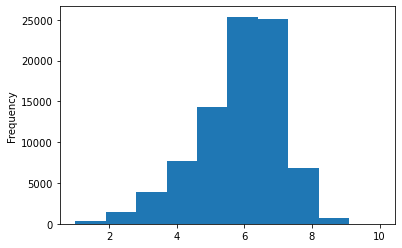

In [12]:
ratings['males_allages_avg_vote'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

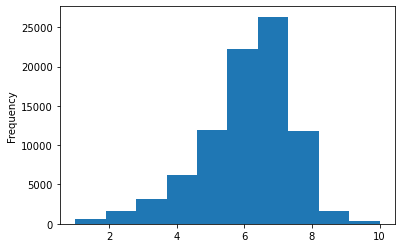

In [13]:
ratings['females_allages_avg_vote'].plot.hist()

In [14]:
most_successful_movies = {2015: ['Star Wars: Episode VII - The Force Awakens',
  'Jurassic World',
  'Fast & Furious 7',
  'Avengers: Age of Ultron',
  'Minions',
  'Spectre',
  'Inside Out',
  'Mission: Impossible - Rogue Nation',
  'The Hunger Games: Mockingjay - Part 2',
  'The Martian'],
 2016: ['Captain America: Civil War',
  'Rogue One',
  'Finding Dory',
  'Zootopia',
  'The Jungle Book',
  'The Secret Life of Pets',
  'Batman v Superman: Dawn of Justice',
  'Fantastic Beasts and Where to Find Them',
  'Deadpool',
  'Suicide Squad'],
 2017: ['Star Wars: Episode VIII - The Last Jedi',
  'Beauty and the Beast',
  'The Fate of the Furious',
  'Despicable Me 3',
  'Jumanji: Welcome to the Jungle',
  'Spider-Man: Homecoming',
  'Zhan lang II',
  'Guardians of the Galaxy Vol. 2',
  'Thor: Ragnarok',
  'Wonder Woman'],
 2018: ['Avengers: Infinity War',
  'Black Panther',
  'Jurassic World: Fallen Kingdom',
  'Incredibles 2',
  'Aquaman',
  'Bohemian Rhapsody',
  'Venom',
  'Mission: Impossible - Fallout',
  'Deadpool 2',
  'Fantastic Beasts: The Crimes of Grindelwald'],
 2019: ['Avengers: Endgame',
  'The Lion King',
  'Frozen II',
  'Spider-Man: Far from Home',
  'Captain Marvel',
  'Joker',
  'Star Wars: Episode IX - The Rise of Skywalker',
  'Toy Story 4',
  'Aladdin',
  'Jumanji: The Next Level'],
 2020: ['Bad Boys for Life',
  'Sonic the Hedgehog',
  'Ba Bai',
  'Dolittle',
  'Birds of Prey: And the Fantabulous Emancipation of One Harley Quinn',
  'Onward',
  'The Invisible Man',
  'The Call of the Wild',
  'Tenet',
  'Tolo Tolo']}

movie_list = sum(most_successful_movies.values(), [])
movie_list

['Star Wars: Episode VII - The Force Awakens',
 'Jurassic World',
 'Fast & Furious 7',
 'Avengers: Age of Ultron',
 'Minions',
 'Spectre',
 'Inside Out',
 'Mission: Impossible - Rogue Nation',
 'The Hunger Games: Mockingjay - Part 2',
 'The Martian',
 'Captain America: Civil War',
 'Rogue One',
 'Finding Dory',
 'Zootopia',
 'The Jungle Book',
 'The Secret Life of Pets',
 'Batman v Superman: Dawn of Justice',
 'Fantastic Beasts and Where to Find Them',
 'Deadpool',
 'Suicide Squad',
 'Star Wars: Episode VIII - The Last Jedi',
 'Beauty and the Beast',
 'The Fate of the Furious',
 'Despicable Me 3',
 'Jumanji: Welcome to the Jungle',
 'Spider-Man: Homecoming',
 'Zhan lang II',
 'Guardians of the Galaxy Vol. 2',
 'Thor: Ragnarok',
 'Wonder Woman',
 'Avengers: Infinity War',
 'Black Panther',
 'Jurassic World: Fallen Kingdom',
 'Incredibles 2',
 'Aquaman',
 'Bohemian Rhapsody',
 'Venom',
 'Mission: Impossible - Fallout',
 'Deadpool 2',
 'Fantastic Beasts: The Crimes of Grindelwald',
 'Aven

In [15]:
imdb = movies.merge(ratings, on='imdb_title_id')
imdb.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
0,tt0369610,Jurassic World,Jurassic World,2015,2015-06-11,"Action, Adventure, Sci-Fi",124,USA,English,Colin Trevorrow,...,7.2,32243.0,7.3,6381.0,6.8,762.0,7.1,72876.0,6.8,217418.0
1,tt0385887,Motherless Brooklyn - I segreti di una città,Motherless Brooklyn,2019,2019-11-07,"Crime, Drama, Mystery",144,USA,"English, French",Edward Norton,...,6.8,1632.0,7.1,837.0,6.3,269.0,6.8,5124.0,6.8,14796.0
2,tt0437086,Alita - Angelo della battaglia,Alita: Battle Angel,2019,2019-02-14,"Action, Adventure, Sci-Fi",122,"USA, Japan, Canada","English, Spanish",Robert Rodriguez,...,7.2,7651.0,7.5,1843.0,6.8,439.0,7.3,22680.0,7.2,83787.0
3,tt0448115,Shazam!,Shazam!,2019,2019-04-03,"Action, Adventure, Comedy",132,"USA, Canada","English, Spanish",David F. Sandberg,...,7.1,8995.0,7.3,2091.0,6.8,525.0,7.3,28394.0,6.9,85782.0
4,tt0451279,Wonder Woman,Wonder Woman,2017,2017-06-01,"Action, Adventure, Fantasy",141,"USA, China, Hong Kong","English, German, Dutch, French, Spanish, Chine...",Patty Jenkins,...,7.6,29053.0,7.8,7220.0,7.0,723.0,7.7,67709.0,7.2,190337.0


In [16]:
imdb.columns

Index(['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'worldwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics', 'weighted_average_vote',
       'total_votes', 'mean_vote', 'median_vote', 'votes_10', 'votes_9',
       'votes_8', 'votes_7', 'votes_6', 'votes_5', 'votes_4', 'votes_3',
       'votes_2', 'votes_1', 'allgenders_0age_avg_vote',
       'allgenders_0age_votes', 'allgenders_18age_avg_vote',
       'allgenders_18age_votes', 'allgenders_30age_avg_vote',
       'allgenders_30age_votes', 'allgenders_45age_avg_vote',
       'allgenders_45age_votes', 'males_allages_avg_vote',
       'males_allages_votes', 'males_0age_avg_vote', 'males_0age_votes',
       'males_18age_avg_vote', 'males_18age_votes', 'males_30age_avg_vote',
       'males_30age_votes

In [17]:
relevant_years = imdb[imdb['year'].isin(most_successful_movies.keys())]
relevant_years.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
0,tt0369610,Jurassic World,Jurassic World,2015,2015-06-11,"Action, Adventure, Sci-Fi",124,USA,English,Colin Trevorrow,...,7.2,32243.0,7.3,6381.0,6.8,762.0,7.1,72876.0,6.8,217418.0
1,tt0385887,Motherless Brooklyn - I segreti di una città,Motherless Brooklyn,2019,2019-11-07,"Crime, Drama, Mystery",144,USA,"English, French",Edward Norton,...,6.8,1632.0,7.1,837.0,6.3,269.0,6.8,5124.0,6.8,14796.0
2,tt0437086,Alita - Angelo della battaglia,Alita: Battle Angel,2019,2019-02-14,"Action, Adventure, Sci-Fi",122,"USA, Japan, Canada","English, Spanish",Robert Rodriguez,...,7.2,7651.0,7.5,1843.0,6.8,439.0,7.3,22680.0,7.2,83787.0
3,tt0448115,Shazam!,Shazam!,2019,2019-04-03,"Action, Adventure, Comedy",132,"USA, Canada","English, Spanish",David F. Sandberg,...,7.1,8995.0,7.3,2091.0,6.8,525.0,7.3,28394.0,6.9,85782.0
4,tt0451279,Wonder Woman,Wonder Woman,2017,2017-06-01,"Action, Adventure, Fantasy",141,"USA, China, Hong Kong","English, German, Dutch, French, Spanish, Chine...",Patty Jenkins,...,7.6,29053.0,7.8,7220.0,7.0,723.0,7.7,67709.0,7.2,190337.0


In [18]:
relevant_years_stdz = relevant_years.apply(standardize_col, axis=0)
relevant_years_stdz.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
0,tt0369610,Jurassic World,Jurassic World,-1.294172,-1.536841,"Action, Adventure, Sci-Fi",0.825079,USA,English,Colin Trevorrow,...,0.790351,4.058516,0.775531,3.418174,1.123500,2.733679,0.702649,4.208965,0.515443,3.712219
1,tt0385887,Motherless Brooklyn - I segreti di una città,Motherless Brooklyn,1.466543,1.511622,"Crime, Drama, Mystery",2.011445,USA,"English, French",Edward Norton,...,0.330721,-0.544581,0.545030,-0.317413,0.574413,-0.194279,0.381114,-0.396925,0.515443,-0.444035
2,tt0437086,Alita - Angelo della battaglia,Alita: Battle Angel,1.466543,1.007963,"Action, Adventure, Sci-Fi",0.706443,"USA, Japan, Canada","English, Spanish",Robert Rodriguez,...,0.790351,0.360520,1.006031,0.360437,1.123500,0.815362,0.917006,0.796560,0.951976,0.971133
3,tt0448115,Shazam!,Shazam!,1.466543,1.098849,"Action, Adventure, Comedy",1.299625,"USA, Canada","English, Spanish",David F. Sandberg,...,0.675443,0.562623,0.775531,0.527541,1.123500,1.326121,0.917006,1.185007,0.624576,1.012055
4,tt0451279,Wonder Woman,Wonder Woman,0.086185,-0.171660,"Action, Adventure, Fantasy",1.833490,"USA, China, Hong Kong","English, German, Dutch, French, Spanish, Chine...",Patty Jenkins,...,1.249981,3.578824,1.351782,3.983498,1.343135,2.502056,1.345719,3.857704,0.951976,3.156724


In [19]:
relevant_years.shape

(993, 70)

0.5802392635264324

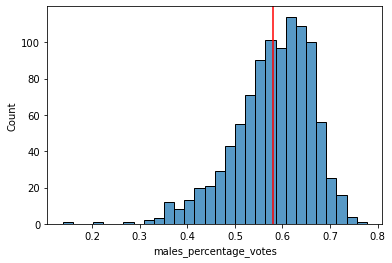

In [20]:
relevant_years['males_percentage_votes'] = relevant_years['males_allages_votes'] / relevant_years['votes']
#relevant_years['males_percentage_votes'].plot.hist(bins=50)
sns.histplot(data=relevant_years, x='males_percentage_votes')
plt.axvline(x=relevant_years['males_percentage_votes'].mean(),
            color='red')
relevant_years['males_percentage_votes'].mean()

We now test, whether the mean of 0.58 is significantly different from 0.5, which we consider the distribution of male and females in the world (our population). 

In [21]:
ttest_1samp(relevant_years['males_percentage_votes'], 0.5)

Ttest_1sampResult(statistic=30.859035907939063, pvalue=4.013537684447491e-147)

The p value let's us reject the Null Hypothesis that females and males are equally (50 % each) in the number of ratings. Hence, the averages tend to cover more male reviewers than female reviewers. We would derive from this result that average scores might be biased towards male opinions. 

Let's have a look at the left and right extremes, just to see what kinds of movies that might be. It looks like there are 3 movies with very low male percentage and 1-5 with a very high. So, we just have a look at the 5 highest and lowest percentage of male votes.

In [22]:
relevant_years[['original_title','males_percentage_votes']].sort_values('males_percentage_votes').head(5)

,original_title,males_percentage_votes
566,Meet the Blacks,0.137320
552,After,0.215840
706,"Everything, Everything",0.278886
548,Forever My Girl,0.327401
855,The Sun Is Also a Star,0.328246


In [23]:
relevant_years[['original_title','males_percentage_votes']].sort_values('males_percentage_votes', ascending=False).head(5)

,original_title,males_percentage_votes
500,Mai sing,0.777633
279,The Gunman,0.748229
466,Turbo Kid,0.746878
730,Kickboxer: Retaliation,0.739533
502,Cop Car,0.736558


In [24]:
relevant_years.sort_values('females_allages_avg_vote', ascending=False)['original_title'].head(60)

967                                    Capharnaüm
250                                          Coco
671                                   The Promise
921                                         Joker
884                                  Gisaengchung
641             Spider-Man: Into the Spider-Verse
558                             Avengers: Endgame
557                        Avengers: Infinity War
746                                Kimi no na wa.
138                             Bohemian Rhapsody
904                                    Green Book
200                                 Hacksaw Ridge
976                                          1917
483                                          Lion
376                                          Room
709     Three Billboards Outside Ebbing, Missouri
345                                      Zootopia
297                                   Jojo Rabbit
198                                    Inside Out
793                          Call Me by Your Name


In [25]:
relevant_years.sort_values('males_allages_avg_vote', ascending=False)['original_title'].head(60)

884                                  Gisaengchung
921                                         Joker
746                                Kimi no na wa.
557                        Avengers: Infinity War
250                                          Coco
641             Spider-Man: Into the Spider-Verse
558                             Avengers: Endgame
976                                          1917
967                                    Capharnaüm
904                                    Green Book
198                                    Inside Out
74                             Mad Max: Fury Road
376                                          Room
168                                Ford v Ferrari
397                                         Logan
200                                 Hacksaw Ridge
709     Three Billboards Outside Ebbing, Missouri
80                                       Deadpool
483                                          Lion
465                                   The Martian


In [26]:
our_movies = imdb[imdb['original_title'].isin(movie_list)]
our_movies.shape

(56, 70)

In [27]:
our_movies['males_allages_avg_vote'].mean()

7.085714285714286

In [28]:
our_movies['females_allages_avg_vote'].mean()

7.403571428571427

/var/folders/10/_7nfqv556wvd8gm4wp6z338h0000gn/T/ipykernel_65568/219860218.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  our_movies['males_percentage_votes'] = our_movies['males_allages_votes'] / our_movies['votes']


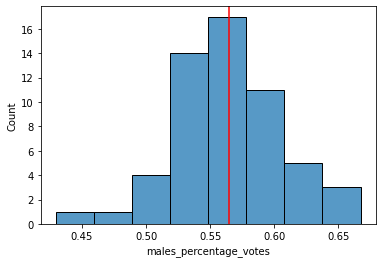

In [29]:
our_movies['males_percentage_votes'] = our_movies['males_allages_votes'] / our_movies['votes']
#relevant_years['males_percentage_votes'].plot.hist(bins=50)
sns.histplot(data=our_movies, x='males_percentage_votes')
plt.axvline(x=our_movies['males_percentage_votes'].mean(),
            color='red')

In [30]:
ttest_1samp(our_movies['males_percentage_votes'], 0.5)

Ttest_1sampResult(statistic=10.906309688756858, pvalue=2.2768094327627752e-15)

In [31]:
our_movies[['original_title', 'males_percentage_votes']].sort_values('males_percentage_votes').head(1)

,original_title,males_percentage_votes
320,Beauty and the Beast,0.429799


In [32]:
our_movies[['original_title', 'males_percentage_votes']].sort_values('males_percentage_votes', ascending=False).head(1)

,original_title,males_percentage_votes
252,Mission: Impossible - Rogue Nation,0.667459


In [33]:
our_movies_stdz = our_movies.apply(standardize_col, axis=0)

## How successful are movies liked by men/women?

<AxesSubplot:xlabel='mean_vote', ylabel='worldwide_gross_income'>

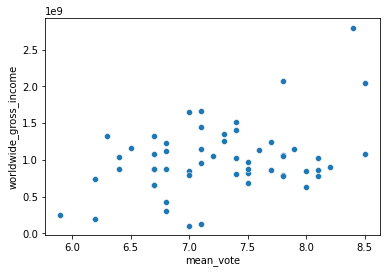

In [34]:
sns.scatterplot(x='mean_vote', y='worldwide_gross_income', data=our_movies)

<AxesSubplot:xlabel='males_allages_avg_vote', ylabel='worldwide_gross_income'>

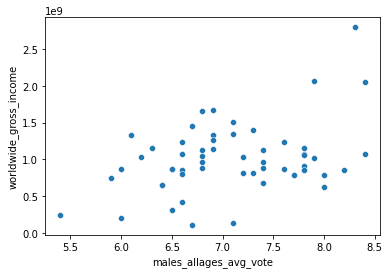

In [35]:
sns.scatterplot(x='males_allages_avg_vote', y='worldwide_gross_income', data=our_movies)

<AxesSubplot:xlabel='females_allages_avg_vote', ylabel='worldwide_gross_income'>

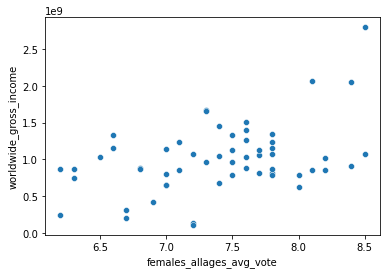

In [36]:
sns.scatterplot(x='females_allages_avg_vote', y='worldwide_gross_income', data=our_movies)

In [37]:
mod = smf.ols(formula='worldwide_gross_income ~ females_allages_avg_vote + males_allages_avg_vote', data=our_movies)

In [38]:
res = mod.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     worldwide_gross_income   R-squared:                       0.189
Model:                                OLS   Adj. R-squared:                  0.158
Method:                     Least Squares   F-statistic:                     6.163
Date:                    Thu, 09 Dec 2021   Prob (F-statistic):            0.00392
Time:                            19:45:41   Log-Likelihood:                -1191.3
No. Observations:                      56   AIC:                             2389.
Df Residuals:                          53   BIC:                             2395.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [39]:
pearsonr(our_movies['females_allages_avg_vote'], our_movies['worldwide_gross_income'])

(0.42898441700785955, 0.0009706411459157718)

In [40]:
pearsonr(our_movies['males_allages_avg_vote'], our_movies['worldwide_gross_income'])

(0.3753249494558498, 0.004367306856286937)

In [41]:
mod = smf.ols(formula='worldwide_gross_income ~ females_allages_avg_vote + males_allages_avg_vote', data=relevant_years)

In [42]:
res = mod.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     worldwide_gross_income   R-squared:                       0.087
Model:                                OLS   Adj. R-squared:                  0.085
Method:                     Least Squares   F-statistic:                     47.29
Date:                    Thu, 09 Dec 2021   Prob (F-statistic):           2.43e-20
Time:                            19:45:41   Log-Likelihood:                -20655.
No. Observations:                     993   AIC:                         4.132e+04
Df Residuals:                         990   BIC:                         4.133e+04
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [43]:
mod = smf.ols(formula='worldwide_gross_income ~ males_allages_avg_vote', data=relevant_years)
res = mod.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     worldwide_gross_income   R-squared:                       0.061
Model:                                OLS   Adj. R-squared:                  0.060
Method:                     Least Squares   F-statistic:                     64.14
Date:                    Thu, 09 Dec 2021   Prob (F-statistic):           3.23e-15
Time:                            19:45:41   Log-Likelihood:                -20669.
No. Observations:                     993   AIC:                         4.134e+04
Df Residuals:                         991   BIC:                         4.135e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [44]:
mod = smf.ols(formula='worldwide_gross_income ~ mean_vote', data=relevant_years)
res = mod.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     worldwide_gross_income   R-squared:                       0.064
Model:                                OLS   Adj. R-squared:                  0.063
Method:                     Least Squares   F-statistic:                     67.68
Date:                    Thu, 09 Dec 2021   Prob (F-statistic):           6.02e-16
Time:                            19:45:41   Log-Likelihood:                -20668.
No. Observations:                     993   AIC:                         4.134e+04
Df Residuals:                         991   BIC:                         4.135e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -

In [45]:
mod = smf.ols(formula='worldwide_gross_income ~ mean_vote + females_allages_avg_vote', data=relevant_years)
res = mod.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     worldwide_gross_income   R-squared:                       0.089
Model:                                OLS   Adj. R-squared:                  0.087
Method:                     Least Squares   F-statistic:                     48.53
Date:                    Thu, 09 Dec 2021   Prob (F-statistic):           7.87e-21
Time:                            19:45:41   Log-Likelihood:                -20654.
No. Observations:                     993   AIC:                         4.131e+04
Df Residuals:                         990   BIC:                         4.133e+04
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [46]:
mod = smf.ols(formula='worldwide_gross_income ~ mean_vote + females_allages_avg_vote + males_allages_avg_vote', data=relevant_years)
res = mod.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     worldwide_gross_income   R-squared:                       0.089
Model:                                OLS   Adj. R-squared:                  0.087
Method:                     Least Squares   F-statistic:                     32.39
Date:                    Thu, 09 Dec 2021   Prob (F-statistic):           5.66e-20
Time:                            19:45:42   Log-Likelihood:                -20654.
No. Observations:                     993   AIC:                         4.132e+04
Df Residuals:                         989   BIC:                         4.134e+04
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

<AxesSubplot:xlabel='mean_vote', ylabel='worldwide_gross_income'>

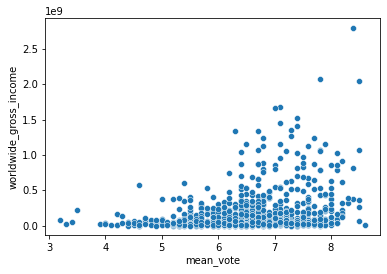

In [47]:
sns.scatterplot(x='mean_vote', y='worldwide_gross_income', data=relevant_years)

<AxesSubplot:xlabel='males_allages_avg_vote', ylabel='worldwide_gross_income'>

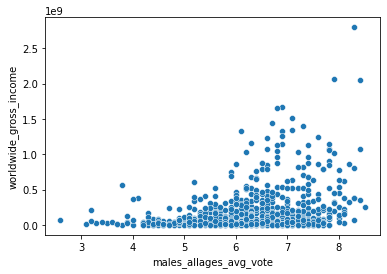

In [48]:
sns.scatterplot(x='males_allages_avg_vote', y='worldwide_gross_income', data=relevant_years)

<AxesSubplot:xlabel='females_allages_avg_vote', ylabel='worldwide_gross_income'>

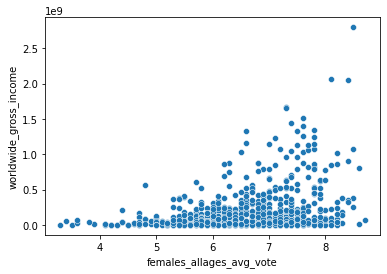

In [49]:
sns.scatterplot(x='females_allages_avg_vote', y='worldwide_gross_income', data=relevant_years)

<AxesSubplot:xlabel='females_allages_avg_vote', ylabel='mean_vote'>

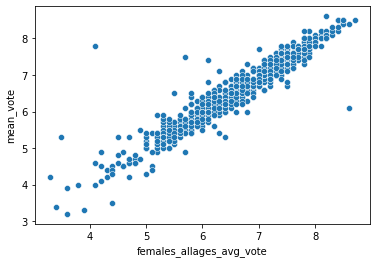

In [50]:
sns.scatterplot(x='females_allages_avg_vote', y='mean_vote', data=relevant_years)

In [51]:
pearsonr(our_movies['females_allages_avg_vote'], our_movies['mean_vote'])

(0.9375038766751962, 2.0150238375185858e-26)

In [52]:
mod = smf.ols(formula='worldwide_gross_income ~ np.power(females_allages_avg_vote, 2)', data=relevant_years)
res = mod.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     worldwide_gross_income   R-squared:                       0.093
Model:                                OLS   Adj. R-squared:                  0.092
Method:                     Least Squares   F-statistic:                     101.3
Date:                    Thu, 09 Dec 2021   Prob (F-statistic):           9.52e-23
Time:                            19:45:44   Log-Likelihood:                -20652.
No. Observations:                     993   AIC:                         4.131e+04
Df Residuals:                         991   BIC:                         4.132e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

## Average vote by men?

6.355991943605238

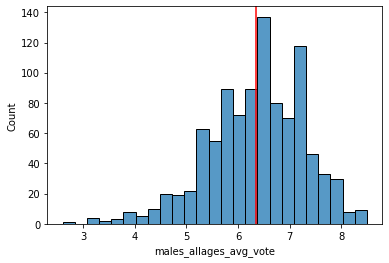

In [53]:
sns.histplot(data=relevant_years, x='males_allages_avg_vote')
plt.axvline(x=relevant_years['males_allages_avg_vote'].mean(),
            color='red')
relevant_years['males_allages_avg_vote'].mean()

6.598791540785492

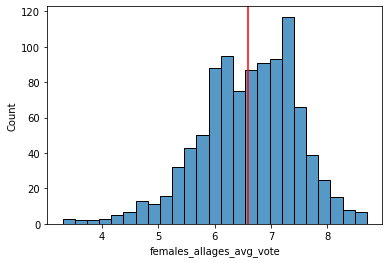

In [54]:
sns.histplot(data=relevant_years, x='females_allages_avg_vote')
plt.axvline(x=relevant_years['females_allages_avg_vote'].mean(),
            color='red')
relevant_years['females_allages_avg_vote'].mean()

Set equal_var to False to not assume that both distributions have an equal variance.

In [55]:
ttest_ind(relevant_years['males_allages_avg_vote'], relevant_years['females_allages_avg_vote'], equal_var=False)

Ttest_indResult(statistic=-6.004186697377894, pvalue=2.282261102655337e-09)

## Young vs old generation? Which generation influences movie success the most?

In [56]:
mod = smf.ols(formula='mean_vote ~ allgenders_0age_avg_vote + allgenders_18age_avg_vote + allgenders_30age_avg_vote + allgenders_45age_avg_vote', data=relevant_years)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              mean_vote   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     3641.
Date:                Thu, 09 Dec 2021   Prob (F-statistic):               0.00
Time:                        19:45:47   Log-Likelihood:                 118.91
No. Observations:                 969   AIC:                            -227.8
Df Residuals:                     964   BIC:                            -203.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [57]:
mod = smf.ols(formula='worldwide_gross_income ~ allgenders_0age_avg_vote + allgenders_18age_avg_vote + allgenders_30age_avg_vote + allgenders_45age_avg_vote', data=relevant_years)
res = mod.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     worldwide_gross_income   R-squared:                       0.072
Model:                                OLS   Adj. R-squared:                  0.068
Method:                     Least Squares   F-statistic:                     18.79
Date:                    Thu, 09 Dec 2021   Prob (F-statistic):           6.84e-15
Time:                            19:45:47   Log-Likelihood:                -20172.
No. Observations:                     969   AIC:                         4.035e+04
Df Residuals:                         964   BIC:                         4.038e+04
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [58]:
mod = smf.ols(formula='worldwide_gross_income ~ allgenders_0age_avg_vote + allgenders_18age_avg_vote + allgenders_30age_avg_vote + allgenders_45age_avg_vote', data=our_movies)
res = mod.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     worldwide_gross_income   R-squared:                       0.174
Model:                                OLS   Adj. R-squared:                  0.110
Method:                     Least Squares   F-statistic:                     2.692
Date:                    Thu, 09 Dec 2021   Prob (F-statistic):             0.0412
Time:                            19:45:47   Log-Likelihood:                -1191.8
No. Observations:                      56   AIC:                             2394.
Df Residuals:                          51   BIC:                             2404.
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------